In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms
from torch.distributions.bernoulli import Bernoulli

In [11]:
import sys
sys.path.append('./../../')

from modules.dvae.model import DVAE
from train_utils.dvae_utils import TemperatureAnnealer
from train_utils.dvae_utils import KLDWeightAnnealer
from train_utils.dvae_utils import KLD_uniform_loss, KLD_codes_uniform_loss

In [12]:
def show(img, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [13]:
class Config:
    DEVICE                = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    in_channels           = 1
    vocab_size            = 32
    num_x2downsamples     = 3
    num_resids_downsample = 3
    num_resids_bottleneck = 4
    hidden_dim            = 256
    NUM_EPOCHS            = 90
    BATCH_SIZE            = 512
    LR                    = 0.1
    LR_gamma              = 0.1
    step_LR_milestones    = [10, 30, 50]
    temp_start            = 5
    temp_end              = 0.01
    temp_steps            = 100 * 30
    KLD_lambda_start      = 0
    KLD_lambda_end        = 6
    KLD_lambda_steps      = 100 * 20
    
    dvae_path             = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/dvae_vocab32_mnist56/"
    dvae_model_name       = "dvae_vocab32_img56"
    data_path             = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/MNIST/"

CONFIG = Config()

In [14]:
data_transforms = torch_transforms.Compose([
    torch_transforms.RandomRotation(10),
    torch_transforms.ToTensor()
])

def collate_fn(data_list):    
    imgs, lables = zip(*data_list)
    
    imgs = torch.stack(imgs, dim=0)
    lables = torch.LongTensor(lables)
    
    b, ch, img_h, img_w = imgs.size()
    
    img_base_h = img_h * 2
    img_base_w = img_w * 2

    img_base = torch.zeros(b, ch, img_base_h, img_base_w)

    coords_list = [(0,0), (0,28), (28,0), (28,28), (14,14)]

    for i in range(b):
        index = np.random.randint(len(coords_list))
        x1, y1 = coords_list[index]

        x2 = x1 + img_w
        y2 = y1 + img_h

        img_base[i, :, y1:y2, x1:x2] = imgs[i, :, :, :]
    
    return img_base, lables

trainset = datasets.MNIST(
    CONFIG.data_path, 
    train=True, 
    transform=data_transforms, 
    download=False)

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn)

temp_annealer = TemperatureAnnealer(
    start_temp=CONFIG.temp_start,
    end_temp=CONFIG.temp_end,
    n_steps=CONFIG.temp_steps)

kl_annealer = KLDWeightAnnealer(
    start_lambda=CONFIG.KLD_lambda_start,
    end_lambda=CONFIG.KLD_lambda_end,
    n_steps=CONFIG.KLD_lambda_steps)


In [15]:
model = DVAE(in_channels=CONFIG.in_channels,
             vocab_size=CONFIG.vocab_size,
             num_x2downsamples=CONFIG.num_x2downsamples,
             num_resids_downsample=CONFIG.num_resids_downsample,
             num_resids_bottleneck=CONFIG.num_resids_bottleneck,
             hidden_dim=CONFIG.hidden_dim)

model.train()
model.to(CONFIG.DEVICE)

optimizer = optim.Adam(model.parameters(), lr=CONFIG.LR)
lr_scheduler = MultiStepLR(optimizer, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)


model.show_model_architecture()

DVAE architecture:

Encoder Model:
  ChangeChannels(in=1, out=32)
  DownSampleX2(in=32, out=64)
  ResidualStack(in=64, out=64, n_resid=3)
  DownSampleX2(in=64, out=128)
  ResidualStack(in=128, out=128, n_resid=3)
  DownSampleX2(in=128, out=256)
  ResidualStack(in=256, out=256, n_resid=3)
  ResidualStack(in=256, out=256, n_resid=4)
  DownSampleX2(in=256, out=32)


Decoder Model:
  ChangeChannels(in=32, out=256)
  ResidualStack(in=256, out=256, n_resid=4)
  DownSampleX2(in=256, out=128)
  ResidualStack(in=128, out=128, n_resid=3)
  DownSampleX2(in=128, out=64)
  ResidualStack(in=64, out=64, n_resid=3)
  DownSampleX2(in=64, out=32)
  ResidualStack(in=32, out=32, n_resid=3)
  ChangeChannels(in=32, out=1)




Device in use: cuda
Epoch: 0 Iter: 39 Loss: 0.099171 Recon Loss 0.098791 KL: 0.003796 N codes used: 32
Epoch: 0 Iter: 79 Loss: 0.071625 Recon Loss 0.071444 KL: 0.00181 N codes used: 32
Epoch: 1 Iter: 119 Loss: 0.061213 Recon Loss 0.060952 KL: 0.002611 N codes used: 32
Epoch: 1 Iter: 159 Loss: 0.052601 Recon Loss 0.052353 KL: 0.002482 N codes used: 32
Epoch: 1 Iter: 199 Loss: 0.049045 Recon Loss 0.048755 KL: 0.002901 N codes used: 32
Epoch: 2 Iter: 239 Loss: 0.04642 Recon Loss 0.046114 KL: 0.00306 N codes used: 32
Epoch: 2 Iter: 279 Loss: 0.045264 Recon Loss 0.044787 KL: 0.004767 N codes used: 32
Epoch: 2 Iter: 319 Loss: 0.042908 Recon Loss 0.042556 KL: 0.003518 N codes used: 32
Epoch: 3 Iter: 359 Loss: 0.042247 Recon Loss 0.04184 KL: 0.004071 N codes used: 32
Epoch: 3 Iter: 399 Loss: 0.038017 Recon Loss 0.037638 KL: 0.003789 N codes used: 32
Epoch: 3 Iter: 439 Loss: 0.035943 Recon Loss 0.03556 KL: 0.003826 N codes used: 32
Epoch: 4 Iter: 479 Loss: 0.034773 Recon Loss 0.034347 KL: 0.004

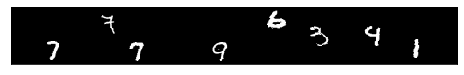

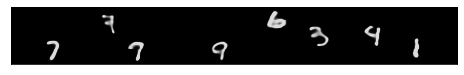

Epoch: 5 Iter: 599 Loss: 0.02841 Recon Loss 0.027886 KL: 0.005242 N codes used: 32
Epoch: 5 Iter: 639 Loss: 0.026833 Recon Loss 0.026294 KL: 0.005385 N codes used: 32
Epoch: 5 Iter: 679 Loss: 0.026385 Recon Loss 0.025796 KL: 0.005891 N codes used: 32
Epoch: 6 Iter: 719 Loss: 0.02538 Recon Loss 0.02478 KL: 0.006001 N codes used: 32
Epoch: 6 Iter: 759 Loss: 0.025181 Recon Loss 0.024566 KL: 0.006149 N codes used: 32
Epoch: 6 Iter: 799 Loss: 0.024944 Recon Loss 0.024314 KL: 0.006307 N codes used: 32
Epoch: 7 Iter: 839 Loss: 0.025446 Recon Loss 0.024782 KL: 0.006645 N codes used: 32
Epoch: 7 Iter: 879 Loss: 0.024521 Recon Loss 0.023858 KL: 0.006632 N codes used: 32
Epoch: 7 Iter: 919 Loss: 0.02366 Recon Loss 0.022905 KL: 0.007557 N codes used: 32
Epoch: 8 Iter: 959 Loss: 0.025469 Recon Loss 0.024671 KL: 0.007975 N codes used: 32
Epoch: 8 Iter: 999 Loss: 0.023767 Recon Loss 0.023013 KL: 0.007542 N codes used: 32
Epoch: 8 Iter: 1039 Loss: 0.02437 Recon Loss 0.023567 KL: 0.00803 N codes used: 

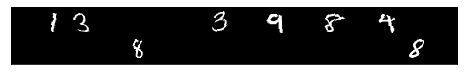

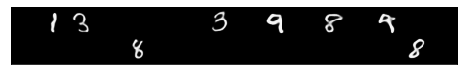

Epoch: 10 Iter: 1199 Loss: 0.022783 Recon Loss 0.021896 KL: 0.008867 N codes used: 32
Epoch: 10 Iter: 1239 Loss: 0.024119 Recon Loss 0.023217 KL: 0.009014 N codes used: 32
Epoch: 10 Iter: 1279 Loss: 0.023374 Recon Loss 0.022457 KL: 0.009168 N codes used: 32
Epoch: 11 Iter: 1319 Loss: 0.02283 Recon Loss 0.021839 KL: 0.00991 N codes used: 32
Epoch: 11 Iter: 1359 Loss: 0.022397 Recon Loss 0.021366 KL: 0.010309 N codes used: 32
Epoch: 11 Iter: 1399 Loss: 0.022361 Recon Loss 0.021289 KL: 0.01072 N codes used: 32
Epoch: 12 Iter: 1439 Loss: 0.022786 Recon Loss 0.021668 KL: 0.011179 N codes used: 32
Epoch: 12 Iter: 1479 Loss: 0.023157 Recon Loss 0.021967 KL: 0.011901 N codes used: 32
Epoch: 12 Iter: 1519 Loss: 0.022648 Recon Loss 0.021353 KL: 0.012945 N codes used: 32
Epoch: 13 Iter: 1559 Loss: 0.023204 Recon Loss 0.021815 KL: 0.013887 N codes used: 32
Epoch: 13 Iter: 1599 Loss: 0.023136 Recon Loss 0.021742 KL: 0.013942 N codes used: 32
Epoch: 13 Iter: 1639 Loss: 0.023012 Recon Loss 0.021537 K

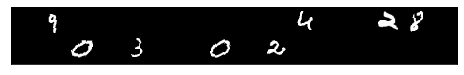

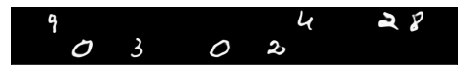

Epoch: 15 Iter: 1799 Loss: 0.022911 Recon Loss 0.021057 KL: 0.018544 N codes used: 32
Epoch: 15 Iter: 1839 Loss: 0.023846 Recon Loss 0.021819 KL: 0.020265 N codes used: 32
Epoch: 15 Iter: 1879 Loss: 0.023629 Recon Loss 0.021472 KL: 0.021572 N codes used: 32
Epoch: 16 Iter: 1919 Loss: 0.023545 Recon Loss 0.02123 KL: 0.02315 N codes used: 32
Epoch: 16 Iter: 1959 Loss: 0.023489 Recon Loss 0.020879 KL: 0.0261 N codes used: 32
Epoch: 16 Iter: 1999 Loss: 0.023989 Recon Loss 0.021294 KL: 0.026943 N codes used: 32
Epoch: 17 Iter: 2039 Loss: 0.024559 Recon Loss 0.021565 KL: 0.029938 N codes used: 32
Epoch: 17 Iter: 2079 Loss: 0.025407 Recon Loss 0.02213 KL: 0.032764 N codes used: 32
Epoch: 17 Iter: 2119 Loss: 0.02513 Recon Loss 0.021541 KL: 0.03589 N codes used: 32
Epoch: 18 Iter: 2159 Loss: 0.025821 Recon Loss 0.021752 KL: 0.040686 N codes used: 32
Epoch: 18 Iter: 2199 Loss: 0.026208 Recon Loss 0.021823 KL: 0.04385 N codes used: 32
Epoch: 18 Iter: 2239 Loss: 0.027356 Recon Loss 0.022565 KL: 0.

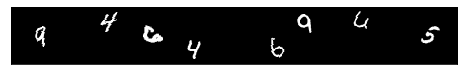

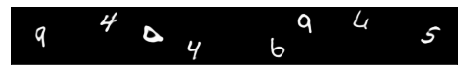

Epoch: 20 Iter: 2399 Loss: 0.030047 Recon Loss 0.022743 KL: 0.073045 N codes used: 32
Epoch: 20 Iter: 2439 Loss: 0.030949 Recon Loss 0.02272 KL: 0.082291 N codes used: 32
Epoch: 21 Iter: 2479 Loss: 0.031989 Recon Loss 0.022803 KL: 0.09186 N codes used: 32
Epoch: 21 Iter: 2519 Loss: 0.033263 Recon Loss 0.023001 KL: 0.10262 N codes used: 32
Epoch: 21 Iter: 2559 Loss: 0.035776 Recon Loss 0.023981 KL: 0.117952 N codes used: 32
Epoch: 22 Iter: 2599 Loss: 0.036673 Recon Loss 0.023738 KL: 0.129344 N codes used: 32
Epoch: 22 Iter: 2639 Loss: 0.038315 Recon Loss 0.023705 KL: 0.146106 N codes used: 32
Epoch: 22 Iter: 2679 Loss: 0.041125 Recon Loss 0.024628 KL: 0.164969 N codes used: 32
Epoch: 23 Iter: 2719 Loss: 0.04354 Recon Loss 0.025495 KL: 0.180455 N codes used: 32
Epoch: 23 Iter: 2759 Loss: 0.045567 Recon Loss 0.025825 KL: 0.197418 N codes used: 32
Epoch: 23 Iter: 2799 Loss: 0.050885 Recon Loss 0.028686 KL: 0.221989 N codes used: 32
Epoch: 24 Iter: 2839 Loss: 0.050575 Recon Loss 0.026681 KL

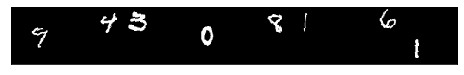

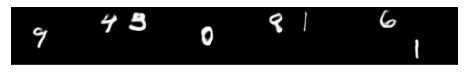

Epoch: 25 Iter: 2959 Loss: 0.056649 Recon Loss 0.031524 KL: 0.251255 N codes used: 32
Epoch: 25 Iter: 2999 Loss: 0.069561 Recon Loss 0.037614 KL: 0.319463 N codes used: 32
Epoch: 25 Iter: 3039 Loss: 0.096858 Recon Loss 0.054671 KL: 0.421871 N codes used: 31
Epoch: 26 Iter: 3079 Loss: 0.086806 Recon Loss 0.050776 KL: 0.360301 N codes used: 30
Epoch: 26 Iter: 3119 Loss: 0.075789 Recon Loss 0.048229 KL: 0.275605 N codes used: 29
Epoch: 26 Iter: 3159 Loss: 0.074802 Recon Loss 0.046068 KL: 0.287337 N codes used: 29
Epoch: 27 Iter: 3199 Loss: 0.07556 Recon Loss 0.047513 KL: 0.280475 N codes used: 29
Epoch: 27 Iter: 3239 Loss: 0.071847 Recon Loss 0.045251 KL: 0.265962 N codes used: 29
Epoch: 27 Iter: 3279 Loss: 0.069874 Recon Loss 0.045082 KL: 0.247915 N codes used: 29
Epoch: 28 Iter: 3319 Loss: 0.065308 Recon Loss 0.042405 KL: 0.229037 N codes used: 29
Epoch: 28 Iter: 3359 Loss: 0.067174 Recon Loss 0.043079 KL: 0.240955 N codes used: 29
Epoch: 28 Iter: 3399 Loss: 0.065148 Recon Loss 0.042716

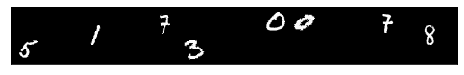

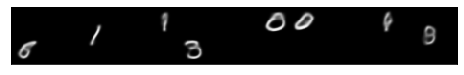

Epoch: 30 Iter: 3559 Loss: 0.065359 Recon Loss 0.042418 KL: 0.229413 N codes used: 29
Epoch: 30 Iter: 3599 Loss: 0.063184 Recon Loss 0.041209 KL: 0.219749 N codes used: 29
Epoch: 30 Iter: 3639 Loss: 0.063296 Recon Loss 0.040889 KL: 0.224072 N codes used: 29
Epoch: 31 Iter: 3679 Loss: 0.06328 Recon Loss 0.040669 KL: 0.226107 N codes used: 29
Epoch: 31 Iter: 3719 Loss: 0.062318 Recon Loss 0.039852 KL: 0.224653 N codes used: 29
Epoch: 31 Iter: 3759 Loss: 0.064088 Recon Loss 0.040789 KL: 0.232996 N codes used: 29
Epoch: 32 Iter: 3799 Loss: 0.064191 Recon Loss 0.041123 KL: 0.230682 N codes used: 29
Epoch: 32 Iter: 3839 Loss: 0.065785 Recon Loss 0.041482 KL: 0.243024 N codes used: 29
Epoch: 32 Iter: 3879 Loss: 0.062775 Recon Loss 0.040727 KL: 0.220485 N codes used: 29
Epoch: 33 Iter: 3919 Loss: 0.062186 Recon Loss 0.040293 KL: 0.218923 N codes used: 29
Epoch: 33 Iter: 3959 Loss: 0.062383 Recon Loss 0.03973 KL: 0.226532 N codes used: 29
Epoch: 33 Iter: 3999 Loss: 0.061938 Recon Loss 0.039625 

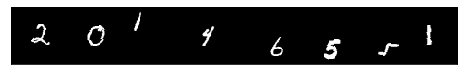

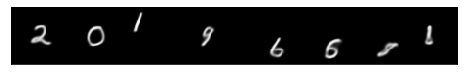

Epoch: 35 Iter: 4159 Loss: 0.061835 Recon Loss 0.039322 KL: 0.225128 N codes used: 29
Epoch: 35 Iter: 4199 Loss: 0.061886 Recon Loss 0.038439 KL: 0.234479 N codes used: 29
Epoch: 35 Iter: 4239 Loss: 0.059016 Recon Loss 0.037372 KL: 0.21644 N codes used: 29
Epoch: 36 Iter: 4279 Loss: 0.062015 Recon Loss 0.040207 KL: 0.218077 N codes used: 29
Epoch: 36 Iter: 4319 Loss: 0.059292 Recon Loss 0.037886 KL: 0.214064 N codes used: 29
Epoch: 36 Iter: 4359 Loss: 0.061585 Recon Loss 0.039103 KL: 0.224811 N codes used: 29
Epoch: 37 Iter: 4399 Loss: 0.059484 Recon Loss 0.037414 KL: 0.220705 N codes used: 29
Epoch: 37 Iter: 4439 Loss: 0.060574 Recon Loss 0.037322 KL: 0.232523 N codes used: 29
Epoch: 37 Iter: 4479 Loss: 0.060682 Recon Loss 0.037822 KL: 0.228595 N codes used: 29
Epoch: 38 Iter: 4519 Loss: 0.06251 Recon Loss 0.037926 KL: 0.245843 N codes used: 29
Epoch: 38 Iter: 4559 Loss: 0.060424 Recon Loss 0.037171 KL: 0.23253 N codes used: 29
Epoch: 38 Iter: 4599 Loss: 0.061889 Recon Loss 0.037261 K

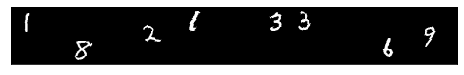

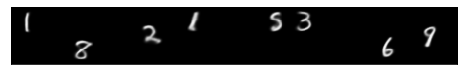

Epoch: 40 Iter: 4759 Loss: 0.060413 Recon Loss 0.038044 KL: 0.223694 N codes used: 29
Epoch: 40 Iter: 4799 Loss: 0.063261 Recon Loss 0.040505 KL: 0.227563 N codes used: 29
Epoch: 41 Iter: 4839 Loss: 0.058992 Recon Loss 0.037177 KL: 0.218159 N codes used: 29
Epoch: 41 Iter: 4879 Loss: 0.058849 Recon Loss 0.037461 KL: 0.213879 N codes used: 29
Epoch: 41 Iter: 4919 Loss: 0.058196 Recon Loss 0.036995 KL: 0.212003 N codes used: 29
Epoch: 42 Iter: 4959 Loss: 0.06034 Recon Loss 0.037485 KL: 0.228546 N codes used: 29
Epoch: 42 Iter: 4999 Loss: 0.063864 Recon Loss 0.039766 KL: 0.240986 N codes used: 29
Epoch: 42 Iter: 5039 Loss: 0.061313 Recon Loss 0.038398 KL: 0.229152 N codes used: 29
Epoch: 43 Iter: 5079 Loss: 0.063883 Recon Loss 0.039127 KL: 0.247559 N codes used: 29
Epoch: 43 Iter: 5119 Loss: 0.059335 Recon Loss 0.037967 KL: 0.213682 N codes used: 29
Epoch: 43 Iter: 5159 Loss: 0.058737 Recon Loss 0.037282 KL: 0.214552 N codes used: 29
Epoch: 44 Iter: 5199 Loss: 0.05994 Recon Loss 0.037482 

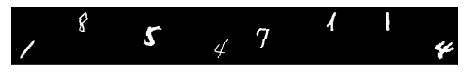

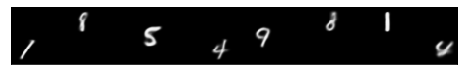

Epoch: 45 Iter: 5319 Loss: 0.060622 Recon Loss 0.037791 KL: 0.228306 N codes used: 29
Epoch: 45 Iter: 5359 Loss: 0.058186 Recon Loss 0.036792 KL: 0.21394 N codes used: 29
Epoch: 45 Iter: 5399 Loss: 0.058 Recon Loss 0.03646 KL: 0.2154 N codes used: 29
Epoch: 46 Iter: 5439 Loss: 0.05771 Recon Loss 0.036689 KL: 0.210208 N codes used: 29
Epoch: 46 Iter: 5479 Loss: 0.057375 Recon Loss 0.035444 KL: 0.219305 N codes used: 29
Epoch: 46 Iter: 5519 Loss: 0.06042 Recon Loss 0.03806 KL: 0.223601 N codes used: 29
Epoch: 47 Iter: 5559 Loss: 0.062514 Recon Loss 0.037151 KL: 0.253628 N codes used: 29
Epoch: 47 Iter: 5599 Loss: 0.059931 Recon Loss 0.03686 KL: 0.230714 N codes used: 29
Epoch: 47 Iter: 5639 Loss: 0.06068 Recon Loss 0.038346 KL: 0.223342 N codes used: 29
Epoch: 48 Iter: 5679 Loss: 0.059498 Recon Loss 0.035997 KL: 0.235009 N codes used: 29
Epoch: 48 Iter: 5719 Loss: 0.057194 Recon Loss 0.035913 KL: 0.212807 N codes used: 29
Epoch: 48 Iter: 5759 Loss: 0.058094 Recon Loss 0.036667 KL: 0.2142

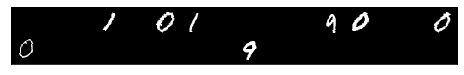

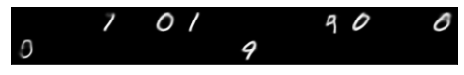

Epoch: 50 Iter: 5919 Loss: 0.060878 Recon Loss 0.036992 KL: 0.23886 N codes used: 29
Epoch: 50 Iter: 5959 Loss: 0.059406 Recon Loss 0.0362 KL: 0.232062 N codes used: 29
Epoch: 50 Iter: 5999 Loss: 0.058498 Recon Loss 0.035538 KL: 0.229597 N codes used: 29
Epoch: 51 Iter: 6039 Loss: 0.060914 Recon Loss 0.037077 KL: 0.238368 N codes used: 29
Epoch: 51 Iter: 6079 Loss: 0.06041 Recon Loss 0.036939 KL: 0.234715 N codes used: 29
Epoch: 51 Iter: 6119 Loss: 0.058514 Recon Loss 0.036566 KL: 0.219473 N codes used: 29
Epoch: 52 Iter: 6159 Loss: 0.05696 Recon Loss 0.035347 KL: 0.21613 N codes used: 29
Epoch: 52 Iter: 6199 Loss: 0.057806 Recon Loss 0.03542 KL: 0.223863 N codes used: 29
Epoch: 52 Iter: 6239 Loss: 0.059194 Recon Loss 0.036313 KL: 0.228808 N codes used: 29
Epoch: 53 Iter: 6279 Loss: 0.060306 Recon Loss 0.03696 KL: 0.233463 N codes used: 29
Epoch: 53 Iter: 6319 Loss: 0.058075 Recon Loss 0.035481 KL: 0.225934 N codes used: 29
Epoch: 53 Iter: 6359 Loss: 0.057026 Recon Loss 0.035847 KL: 0.

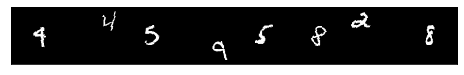

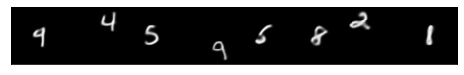

Epoch: 55 Iter: 6519 Loss: 0.056531 Recon Loss 0.036068 KL: 0.204631 N codes used: 29
Epoch: 55 Iter: 6559 Loss: 0.057137 Recon Loss 0.035679 KL: 0.214579 N codes used: 29
Epoch: 55 Iter: 6599 Loss: 0.058237 Recon Loss 0.036365 KL: 0.218722 N codes used: 29
Epoch: 56 Iter: 6639 Loss: 0.06078 Recon Loss 0.037724 KL: 0.23056 N codes used: 29
Epoch: 56 Iter: 6679 Loss: 0.058681 Recon Loss 0.036539 KL: 0.221411 N codes used: 29
Epoch: 56 Iter: 6719 Loss: 0.060686 Recon Loss 0.037665 KL: 0.230205 N codes used: 29
Epoch: 57 Iter: 6759 Loss: 0.058575 Recon Loss 0.036524 KL: 0.220513 N codes used: 29
Epoch: 57 Iter: 6799 Loss: 0.058521 Recon Loss 0.035867 KL: 0.226539 N codes used: 29
Epoch: 57 Iter: 6839 Loss: 0.058427 Recon Loss 0.036298 KL: 0.221285 N codes used: 29
Epoch: 58 Iter: 6879 Loss: 0.060391 Recon Loss 0.036947 KL: 0.234442 N codes used: 29
Epoch: 58 Iter: 6919 Loss: 0.059144 Recon Loss 0.036964 KL: 0.221804 N codes used: 29
Epoch: 58 Iter: 6959 Loss: 0.058052 Recon Loss 0.036988 

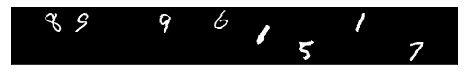

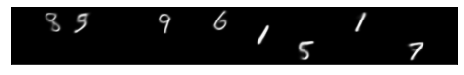

Epoch: 60 Iter: 7119 Loss: 0.056707 Recon Loss 0.034451 KL: 0.222562 N codes used: 29
Epoch: 60 Iter: 7159 Loss: 0.058562 Recon Loss 0.036717 KL: 0.218441 N codes used: 29
Epoch: 61 Iter: 7199 Loss: 0.05716 Recon Loss 0.035951 KL: 0.212083 N codes used: 29
Epoch: 61 Iter: 7239 Loss: 0.057039 Recon Loss 0.035146 KL: 0.218926 N codes used: 29
Epoch: 61 Iter: 7279 Loss: 0.056956 Recon Loss 0.036095 KL: 0.208607 N codes used: 29
Epoch: 62 Iter: 7319 Loss: 0.056762 Recon Loss 0.034946 KL: 0.218161 N codes used: 29
Epoch: 62 Iter: 7359 Loss: 0.05809 Recon Loss 0.0361 KL: 0.219893 N codes used: 29
Epoch: 62 Iter: 7399 Loss: 0.056971 Recon Loss 0.035227 KL: 0.21744 N codes used: 29
Epoch: 63 Iter: 7439 Loss: 0.057398 Recon Loss 0.035489 KL: 0.21909 N codes used: 29
Epoch: 63 Iter: 7479 Loss: 0.05767 Recon Loss 0.036283 KL: 0.213872 N codes used: 29
Epoch: 63 Iter: 7519 Loss: 0.056495 Recon Loss 0.035255 KL: 0.2124 N codes used: 29
Epoch: 64 Iter: 7559 Loss: 0.058863 Recon Loss 0.037884 KL: 0.2

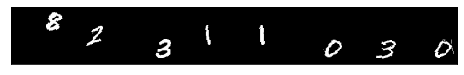

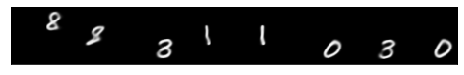

Epoch: 65 Iter: 7679 Loss: 0.056913 Recon Loss 0.035589 KL: 0.213232 N codes used: 29
Epoch: 65 Iter: 7719 Loss: 0.056437 Recon Loss 0.035233 KL: 0.212034 N codes used: 29
Epoch: 65 Iter: 7759 Loss: 0.057172 Recon Loss 0.03547 KL: 0.21702 N codes used: 29
Epoch: 66 Iter: 7799 Loss: 0.057819 Recon Loss 0.035624 KL: 0.221946 N codes used: 29
Epoch: 66 Iter: 7839 Loss: 0.057816 Recon Loss 0.036119 KL: 0.216973 N codes used: 29
Epoch: 66 Iter: 7879 Loss: 0.056785 Recon Loss 0.035344 KL: 0.214409 N codes used: 29
Epoch: 67 Iter: 7919 Loss: 0.058705 Recon Loss 0.035632 KL: 0.230728 N codes used: 29
Epoch: 67 Iter: 7959 Loss: 0.057358 Recon Loss 0.034873 KL: 0.224844 N codes used: 29
Epoch: 67 Iter: 7999 Loss: 0.056308 Recon Loss 0.034598 KL: 0.217104 N codes used: 29
Epoch: 68 Iter: 8039 Loss: 0.057722 Recon Loss 0.035125 KL: 0.225967 N codes used: 29
Epoch: 68 Iter: 8079 Loss: 0.056854 Recon Loss 0.034917 KL: 0.219366 N codes used: 29
Epoch: 68 Iter: 8119 Loss: 0.057734 Recon Loss 0.035285 

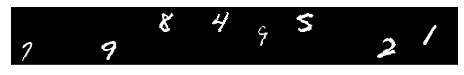

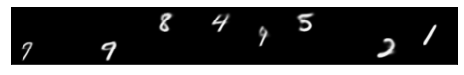

Epoch: 70 Iter: 8279 Loss: 0.055753 Recon Loss 0.035184 KL: 0.20569 N codes used: 29
Epoch: 70 Iter: 8319 Loss: 0.057053 Recon Loss 0.035804 KL: 0.212481 N codes used: 29
Epoch: 70 Iter: 8359 Loss: 0.056892 Recon Loss 0.035402 KL: 0.214899 N codes used: 29
Epoch: 71 Iter: 8399 Loss: 0.057076 Recon Loss 0.036439 KL: 0.206373 N codes used: 29
Epoch: 71 Iter: 8439 Loss: 0.057834 Recon Loss 0.035522 KL: 0.223118 N codes used: 29
Epoch: 71 Iter: 8479 Loss: 0.057905 Recon Loss 0.03522 KL: 0.226848 N codes used: 29
Epoch: 72 Iter: 8519 Loss: 0.059064 Recon Loss 0.035994 KL: 0.230699 N codes used: 29
Epoch: 72 Iter: 8559 Loss: 0.05693 Recon Loss 0.035151 KL: 0.217791 N codes used: 29
Epoch: 72 Iter: 8599 Loss: 0.056555 Recon Loss 0.034827 KL: 0.217285 N codes used: 29
Epoch: 73 Iter: 8639 Loss: 0.056754 Recon Loss 0.034863 KL: 0.218907 N codes used: 29
Epoch: 73 Iter: 8679 Loss: 0.055738 Recon Loss 0.034284 KL: 0.214547 N codes used: 29
Epoch: 73 Iter: 8719 Loss: 0.056981 Recon Loss 0.035307 K

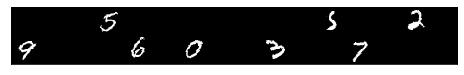

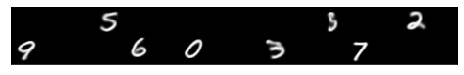

Epoch: 75 Iter: 8879 Loss: 0.057191 Recon Loss 0.033591 KL: 0.236004 N codes used: 29
Epoch: 75 Iter: 8919 Loss: 0.056658 Recon Loss 0.034867 KL: 0.217911 N codes used: 29
Epoch: 75 Iter: 8959 Loss: 0.055896 Recon Loss 0.034886 KL: 0.210103 N codes used: 29
Epoch: 76 Iter: 8999 Loss: 0.05604 Recon Loss 0.034485 KL: 0.215544 N codes used: 29
Epoch: 76 Iter: 9039 Loss: 0.056435 Recon Loss 0.035532 KL: 0.209036 N codes used: 29
Epoch: 76 Iter: 9079 Loss: 0.056625 Recon Loss 0.034994 KL: 0.216315 N codes used: 29
Epoch: 77 Iter: 9119 Loss: 0.05744 Recon Loss 0.035164 KL: 0.222756 N codes used: 29
Epoch: 77 Iter: 9159 Loss: 0.056351 Recon Loss 0.034927 KL: 0.214239 N codes used: 29
Epoch: 77 Iter: 9199 Loss: 0.055929 Recon Loss 0.034773 KL: 0.211561 N codes used: 29
Epoch: 78 Iter: 9239 Loss: 0.056189 Recon Loss 0.034206 KL: 0.219824 N codes used: 29
Epoch: 78 Iter: 9279 Loss: 0.054474 Recon Loss 0.033916 KL: 0.205573 N codes used: 29
Epoch: 78 Iter: 9319 Loss: 0.056518 Recon Loss 0.035526 

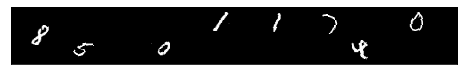

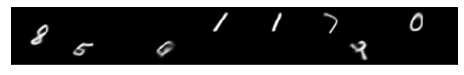

Epoch: 80 Iter: 9479 Loss: 0.056946 Recon Loss 0.035553 KL: 0.213932 N codes used: 29
Epoch: 80 Iter: 9519 Loss: 0.056663 Recon Loss 0.03581 KL: 0.208527 N codes used: 29
Epoch: 81 Iter: 9559 Loss: 0.058401 Recon Loss 0.036688 KL: 0.217134 N codes used: 29
Epoch: 81 Iter: 9599 Loss: 0.057109 Recon Loss 0.035205 KL: 0.21904 N codes used: 29
Epoch: 81 Iter: 9639 Loss: 0.057865 Recon Loss 0.036316 KL: 0.215494 N codes used: 29
Epoch: 82 Iter: 9679 Loss: 0.057776 Recon Loss 0.035968 KL: 0.218072 N codes used: 29
Epoch: 82 Iter: 9719 Loss: 0.056241 Recon Loss 0.035206 KL: 0.210348 N codes used: 29
Epoch: 82 Iter: 9759 Loss: 0.056244 Recon Loss 0.034921 KL: 0.213227 N codes used: 29
Epoch: 83 Iter: 9799 Loss: 0.057591 Recon Loss 0.03604 KL: 0.215518 N codes used: 29
Epoch: 83 Iter: 9839 Loss: 0.058249 Recon Loss 0.036095 KL: 0.221544 N codes used: 29
Epoch: 83 Iter: 9879 Loss: 0.058785 Recon Loss 0.037285 KL: 0.214994 N codes used: 29
Epoch: 84 Iter: 9919 Loss: 0.057771 Recon Loss 0.036726 K

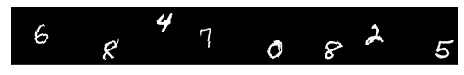

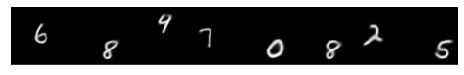

Epoch: 85 Iter: 10039 Loss: 0.059481 Recon Loss 0.036694 KL: 0.227866 N codes used: 29
Epoch: 85 Iter: 10079 Loss: 0.058881 Recon Loss 0.037431 KL: 0.214496 N codes used: 29
Epoch: 85 Iter: 10119 Loss: 0.058477 Recon Loss 0.035844 KL: 0.22633 N codes used: 29
Epoch: 86 Iter: 10159 Loss: 0.058582 Recon Loss 0.036778 KL: 0.21804 N codes used: 29
Epoch: 86 Iter: 10199 Loss: 0.056633 Recon Loss 0.03529 KL: 0.213435 N codes used: 29
Epoch: 86 Iter: 10239 Loss: 0.056128 Recon Loss 0.035242 KL: 0.208857 N codes used: 29
Epoch: 87 Iter: 10279 Loss: 0.056608 Recon Loss 0.035919 KL: 0.206896 N codes used: 29
Epoch: 87 Iter: 10319 Loss: 0.057214 Recon Loss 0.036687 KL: 0.205267 N codes used: 29
Epoch: 87 Iter: 10359 Loss: 0.058151 Recon Loss 0.036986 KL: 0.211646 N codes used: 29
Epoch: 88 Iter: 10399 Loss: 0.057382 Recon Loss 0.03584 KL: 0.215423 N codes used: 29
Epoch: 88 Iter: 10439 Loss: 0.060122 Recon Loss 0.035805 KL: 0.243164 N codes used: 29
Epoch: 88 Iter: 10479 Loss: 0.057092 Recon Loss

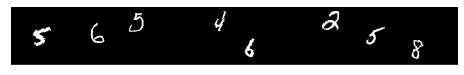

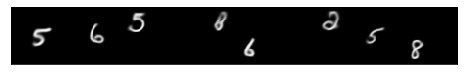

In [16]:
print("Device in use: {}".format(CONFIG.DEVICE))

loss_history = []
recon_loss_history = []
kl_loss_history = []
n_used_codes_history = []
kl_weight_history = []
temp_history = []

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for x, _ in train_loader:
        x = x.to(CONFIG.DEVICE)

        optimizer.zero_grad()

        temp = temp_annealer.step(iteration)
        x_recon, z_logits, z = model(x, temp)

        recon_loss = F.binary_cross_entropy(x_recon, x)

        kld_codes_loss = KLD_codes_uniform_loss(z)

        loss = recon_loss + 0.1 * kld_codes_loss

        # dist = Bernoulli(probs=x_recon)
        # recon_loss = - dist.log_prob((x > 0).float()).mean()

        # kld_loss = KLD_uniform_loss(z_logits)
        # kl_weight = kl_annealer.step(iteration)
        
        # loss = recon_loss + kl_weight * kld_loss

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            n_used_codes = len(z.detach().cpu().argmax(dim=1).view(-1).unique())
            if (iteration + 1) % 40 == 0:
                print("Epoch: {} Iter: {} Loss: {} Recon Loss {} KL: {} N codes used: {}".format(
                    epoch, iteration, 
                    round(loss.item(), 6), 
                    round(recon_loss.item(), 6), 
                    round(kld_codes_loss.item(), 6), 
                    round(n_used_codes, 6)
                ))
        
        loss_history.append(loss.item())
        recon_loss_history.append(recon_loss.item())
        # kl_loss_history.append(kld_loss.item())
        # kl_weight_history.append(kl_weight)
        temp_history.append(temp)
        n_used_codes_history.append(n_used_codes)
        
        iteration += 1
    
    if (epoch + 1) % 5 == 0:
        print("====== Epoch {} ======".format(epoch))
        img_grid = make_grid(x[:8, :, :, :].detach().cpu())
        show(img_grid)
        img_recon_grid = make_grid(x_recon[:8, :, :, :].detach().cpu())
        show(img_recon_grid)
        print("======================")


In [8]:
model.save_model(root_path=CONFIG.dvae_path, model_name=CONFIG.dvae_model_name)

# torch.save(model.encoder.state_dict(), "./gdrive/MyDrive/Colab Notebooks/thesis/dvae_M_mnist_encoder.pth")
# torch.save(model.decoder.state_dict(), "./gdrive/MyDrive/Colab Notebooks/thesis/dvae_M_mnist_decoder.pth")

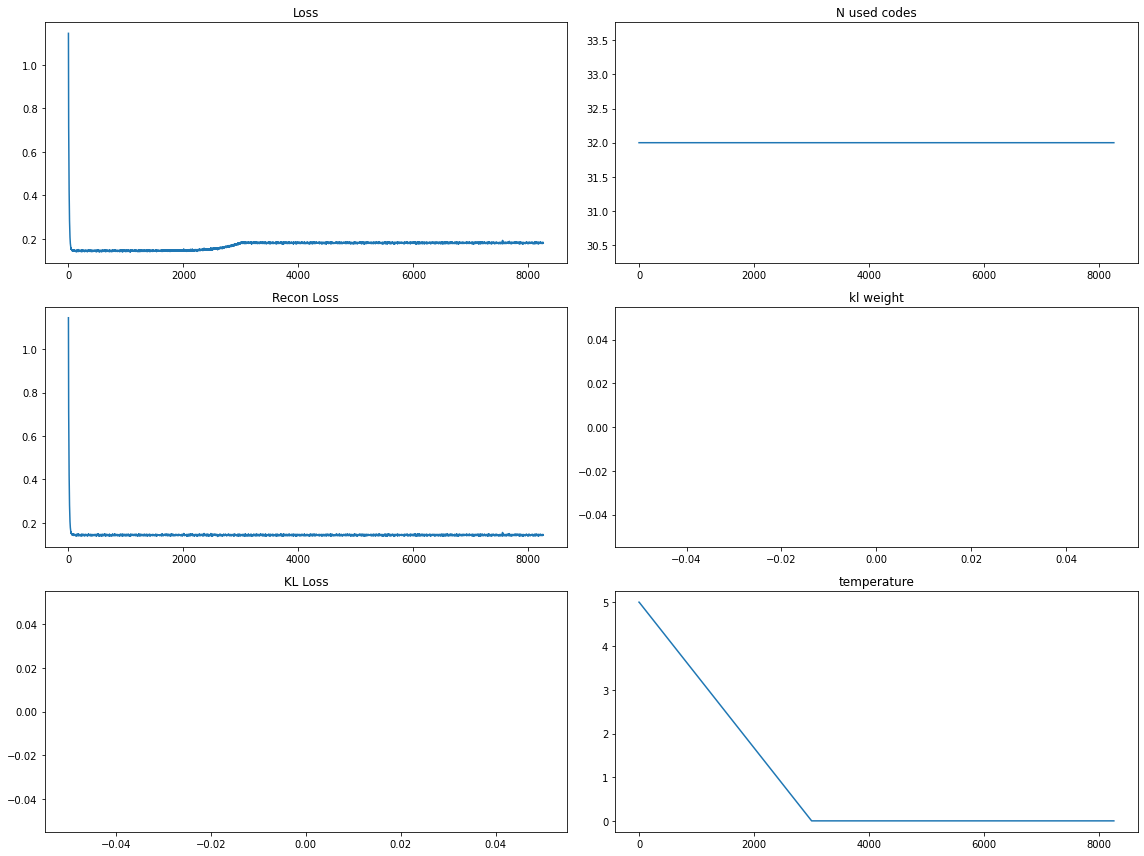

In [9]:
fig = plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(loss_history)
plt.title("Loss")

plt.subplot(3, 2, 3)
plt.plot(recon_loss_history)
plt.title("Recon Loss")

plt.subplot(3, 2, 5)
plt.plot(kl_loss_history)
plt.title("KL Loss")

plt.subplot(3, 2, 2)
plt.plot(n_used_codes_history)
plt.title("N used codes")

plt.subplot(3, 2, 4)
plt.plot(kl_weight_history)
plt.title("kl weight")

plt.subplot(3, 2, 6)
plt.plot(temp_history)
plt.title("temperature")

plt.tight_layout()
plt.show()

In [17]:
1024 / 4

256.0